# 1-Data cleaning

-Identifying outliers in the target variable

-Checking ID column

# 2-Feature Engineering

-Log transformation of target variable

-Concatenation of training set with test set

-Identifying NA values

-Boxcox transformation of skewed features

-Creating dummy variables to replace of categorical variables

-Splitting concatenated data into training and test sets

-Finding outliers

# 3-Models

-Cross-validation strategy

-Ridge regression

-Plotting coefficients of the regression model to identify important features

-Lasso regression

-XGboost

-Kernel Ridge Regression

-Elastic Net Regression

# 4-Creating an ensemble by stacking various models

# 5-Making predictions of the test data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score , KFold

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 1-Data cleaning

### Identifying outliers in the target variable

Text(0,0.5,'SalePrice')

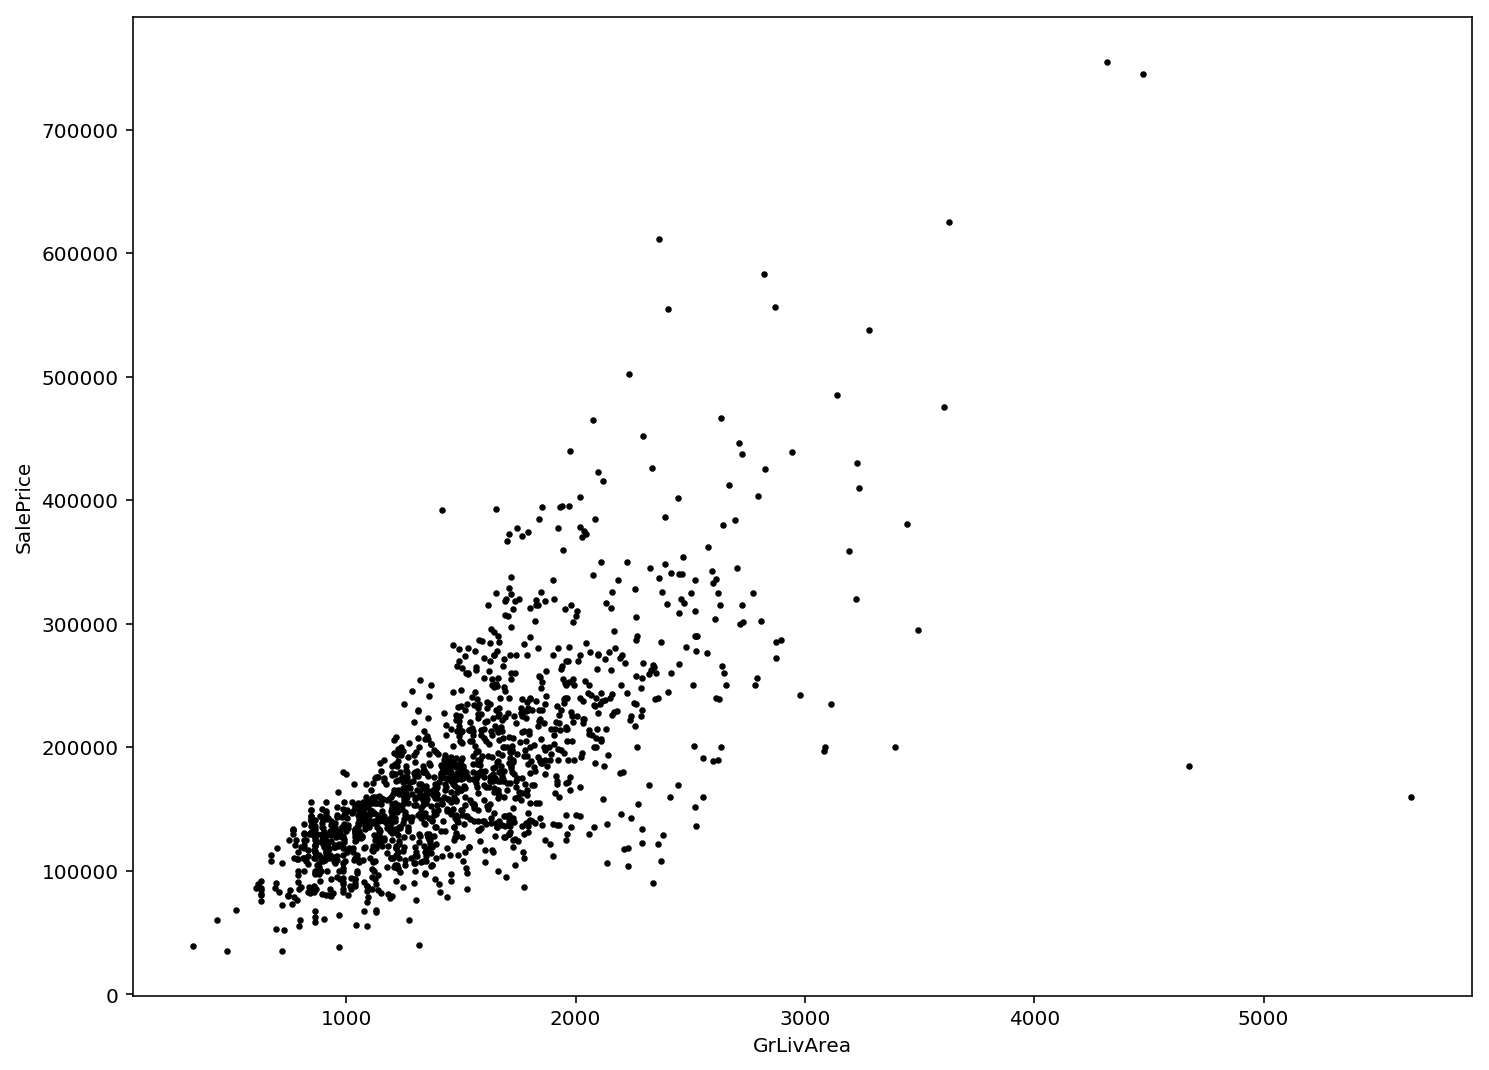

In [3]:
plt.figure(figsize=(12,9)) 
marker_size=5
plt.scatter(train.GrLivArea, train.SalePrice ,marker_size, c='k')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

Text(0,0.5,'SalePrice')

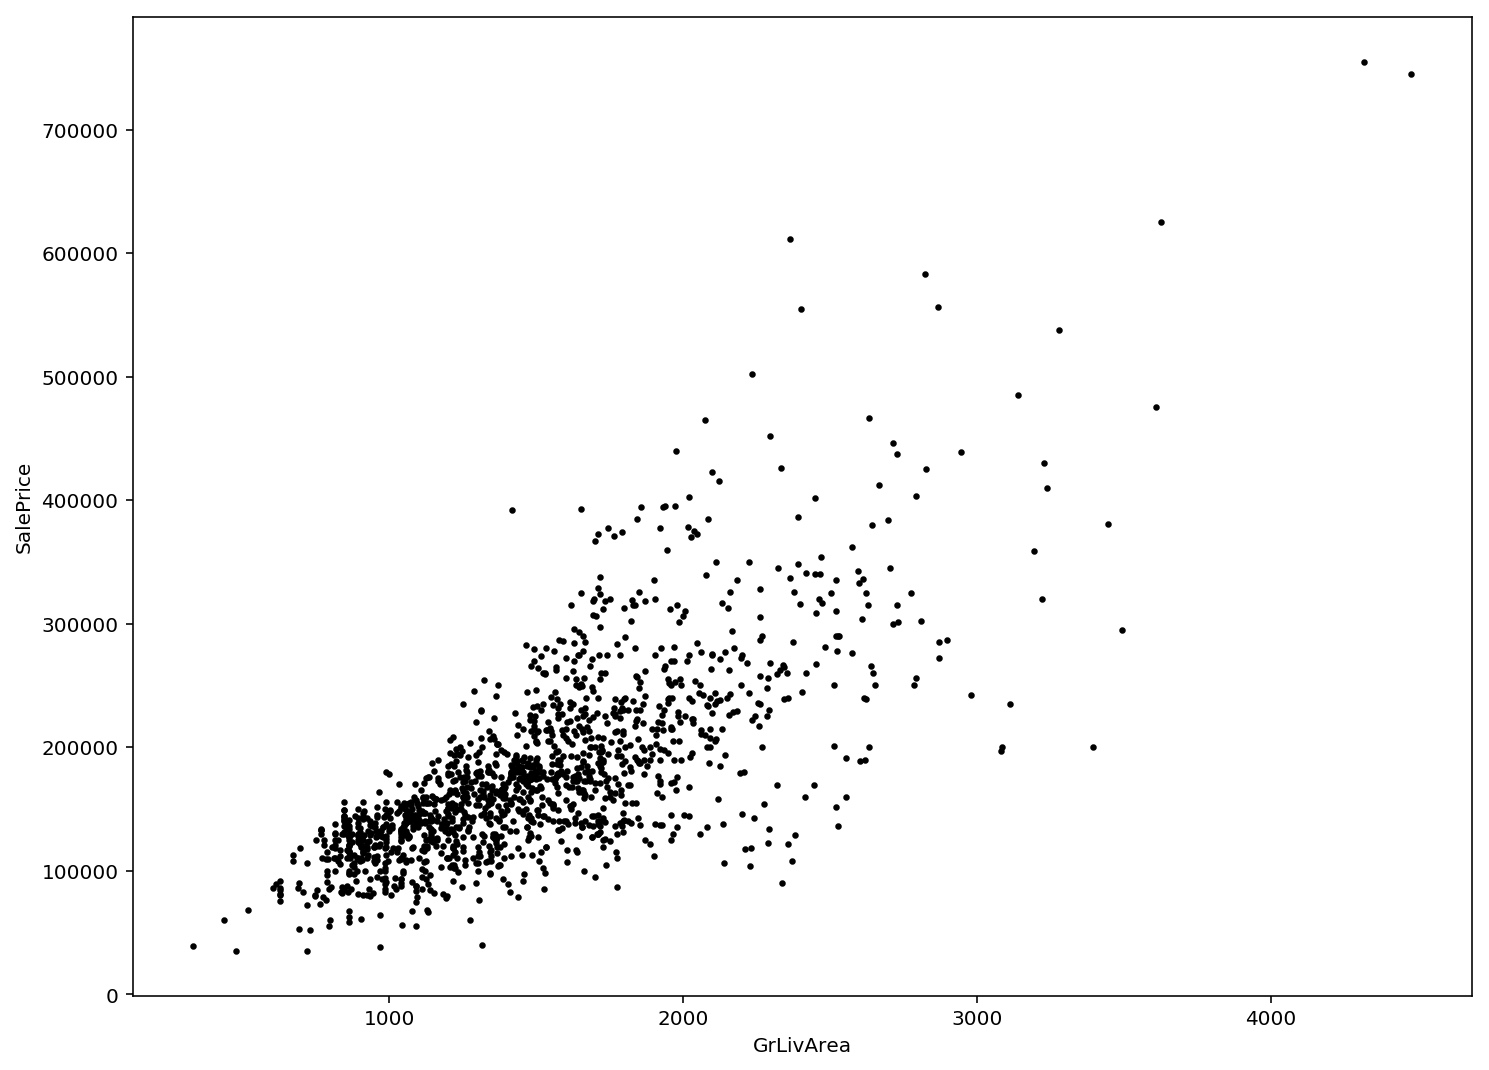

In [4]:
train = train[train.GrLivArea < 4500]

plt.figure(figsize=(12,9)) 
marker_size=5
plt.scatter(train.GrLivArea, train.SalePrice ,marker_size, c='k')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

### Checking ID column

In [5]:
print("Train set size:", train.shape)

Train set size: (1458, 81)


In [6]:
print(len(np.unique(train['Id'])) == len(train))
len(np.unique(test['Id'])) == len(test)

True


True

In [7]:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

# 2-Feature  Engineering

### Log transformation of target variable

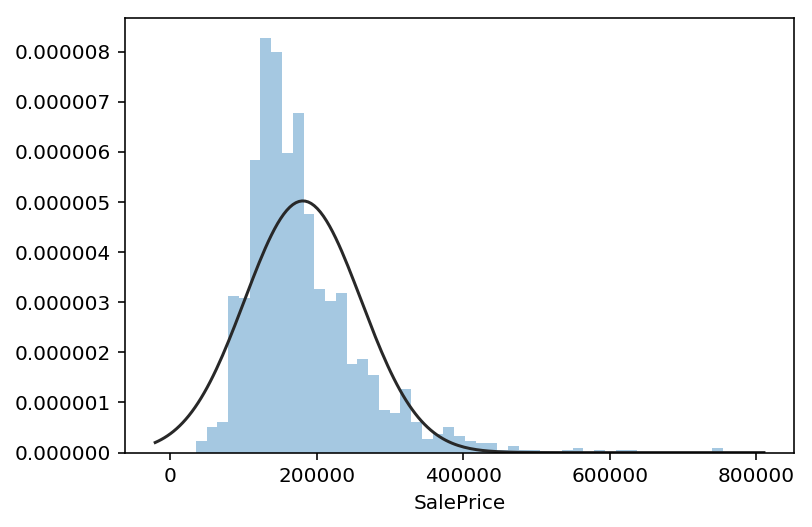

In [8]:
sns.distplot(train.SalePrice, kde=False, fit = norm)

In [9]:
train.SalePrice = np.log1p(train.SalePrice)

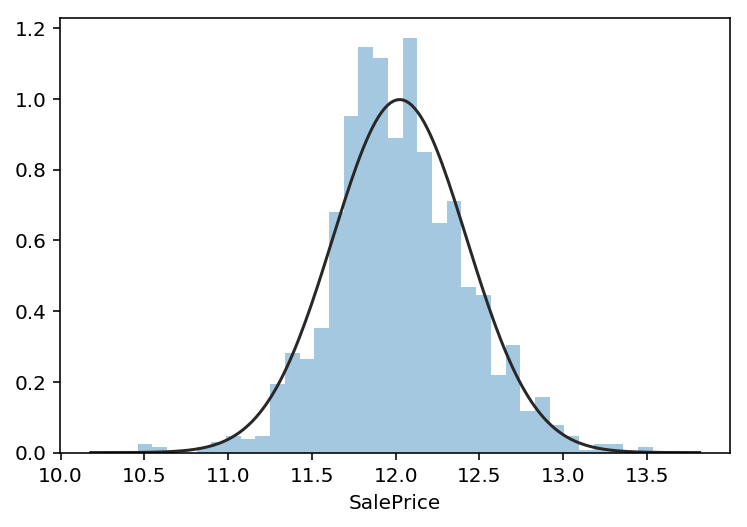

In [10]:
sns.distplot(train.SalePrice, kde=False, fit = norm)

### Concatenation of trainig set with test set

In [11]:
# Dropping sale price column from training data
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1) 
test_features = test

In [12]:
# Concatenation of training and test data prior to feature engineering
all_data_features = pd.concat([train_features, test_features]).reset_index(drop=True) 
all_data_features.shape

(2917, 79)

### Identifying NA values

In [13]:
nulls = np.sum(all_data_features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = all_data_features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                 0        1
PoolQC        2908   object
MiscFeature   2812   object
Alley         2719   object
Fence         2346   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

In [14]:
#Filling NA values of Object type with "None"
objects = []
for i in all_data_features.columns:
    if all_data_features[i].dtype == object:
        objects.append(i)

all_data_features.update(all_data_features[objects].fillna('None'))

nulls = np.sum(all_data_features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = all_data_features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                0        1
LotFrontage   486  float64
GarageYrBlt   159  float64
MasVnrArea     23  float64
BsmtFullBath    2  float64
BsmtHalfBath    2  float64
BsmtFinSF1      1  float64
BsmtFinSF2      1  float64
BsmtUnfSF       1  float64
TotalBsmtSF     1  float64
GarageCars      1  float64
GarageArea      1  float64
There are 11 columns with missing values


In [15]:
#Filling NA values of NUmerical type with "0"
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in all_data_features.columns:
    if all_data_features[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
all_data_features.update(all_data_features[numerics].fillna(0))

nulls = np.sum(all_data_features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = all_data_features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


### Boxcox transformation of skewed features

In [16]:
# Findinf skewness of various features
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in all_data_features.columns:
    if all_data_features[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = all_data_features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [17]:
# Using Boxcox transformation to reduce skewness

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    all_data_features[i]= boxcox1p(all_data_features[i], boxcox_normmax(all_data_features[i]+1))

        
skew_features2 = all_data_features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149133
MasVnrArea,0.977618


### Creating dummy variables to replace of categorical variables

In [18]:
all_data_features.shape

(2917, 79)

In [19]:
final_features = pd.get_dummies(all_data_features).reset_index(drop=True)
final_features.shape

(2917, 309)

### Splitting concatenated data into training and test sets

In [20]:
y.shape

(1458,)

In [21]:
X = final_features.iloc[:len(y),:]
testing_features = final_features.iloc[len(X):,:]

print(X.shape)

print(testing_features.shape)

(1458, 309)
(1459, 309)


### Finding outliers

#removing outlies will reduce the likelihood of overfitting

import statsmodels.api as sm

ols = sm.OLS(endog = y, exog = X)

fit = ols.fit()
test2 = fit.outlier_test()['bonf(p)']

outliers = list(test2[test2<1e-3].index) 

outliers

In [22]:
outliers = [88, 462, 631, 967, 1322]

In [23]:
#Dropping outliers
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

# 3-Models

### Cross-validation strategy

In [24]:
#Returning cross-validation error for a 5-fold split of training set
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

#Returning prediction error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Ridge regression

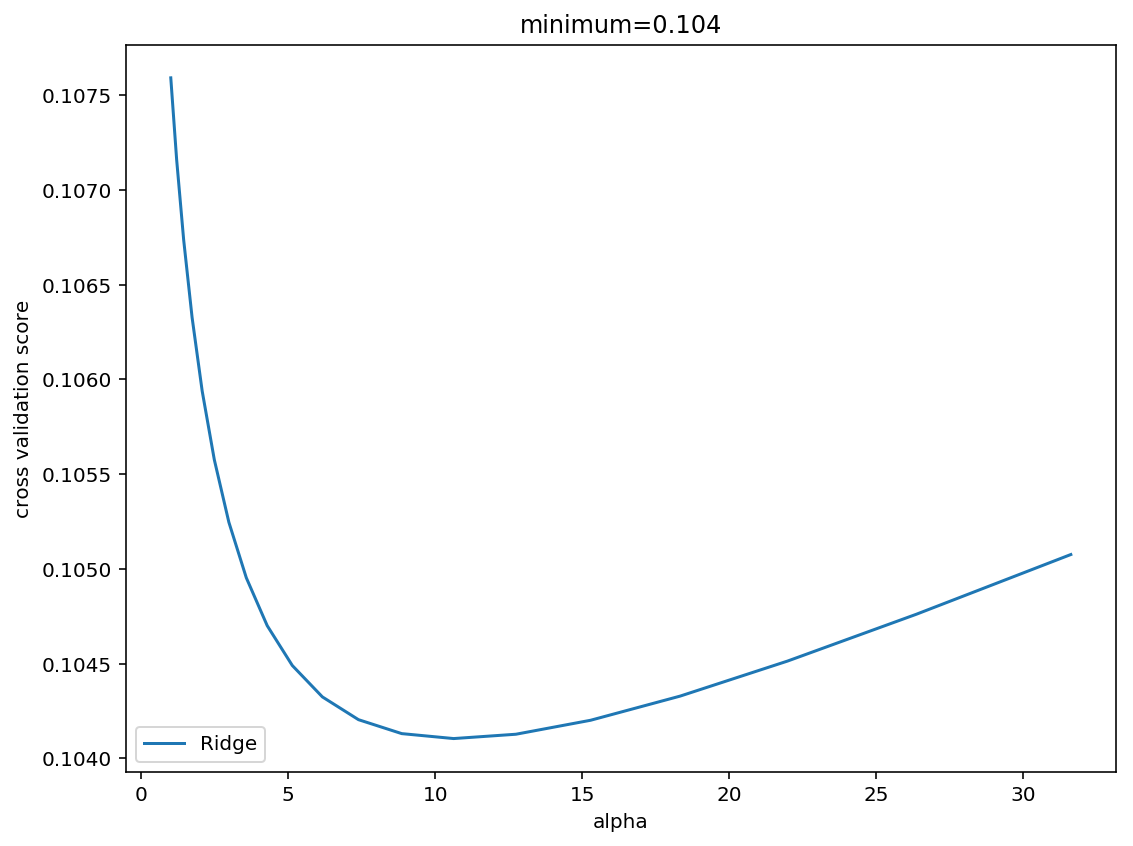

In [25]:
#Plotting cross-validation error for a range learning rates (alpha)
alphas = np.logspace(-0, 1.5, 20)

cv_ridge = [rmse_cv(make_pipeline(RobustScaler(),Ridge(alpha = alpha))).mean() 
            for alpha in alphas]

plt.figure(figsize=(8,6)) 
plt.plot(alphas, cv_ridge, label=Ridge.__name__)
plt.title('minimum=%1.3f' %min(cv_ridge))
plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [26]:
#setting the learning rate (alpha) equal to the optimum values (10)
model_ridge = Ridge(alpha=10)
model_ridge.fit(X,y)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### Plotting coefficients of the regression model to identify important features

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

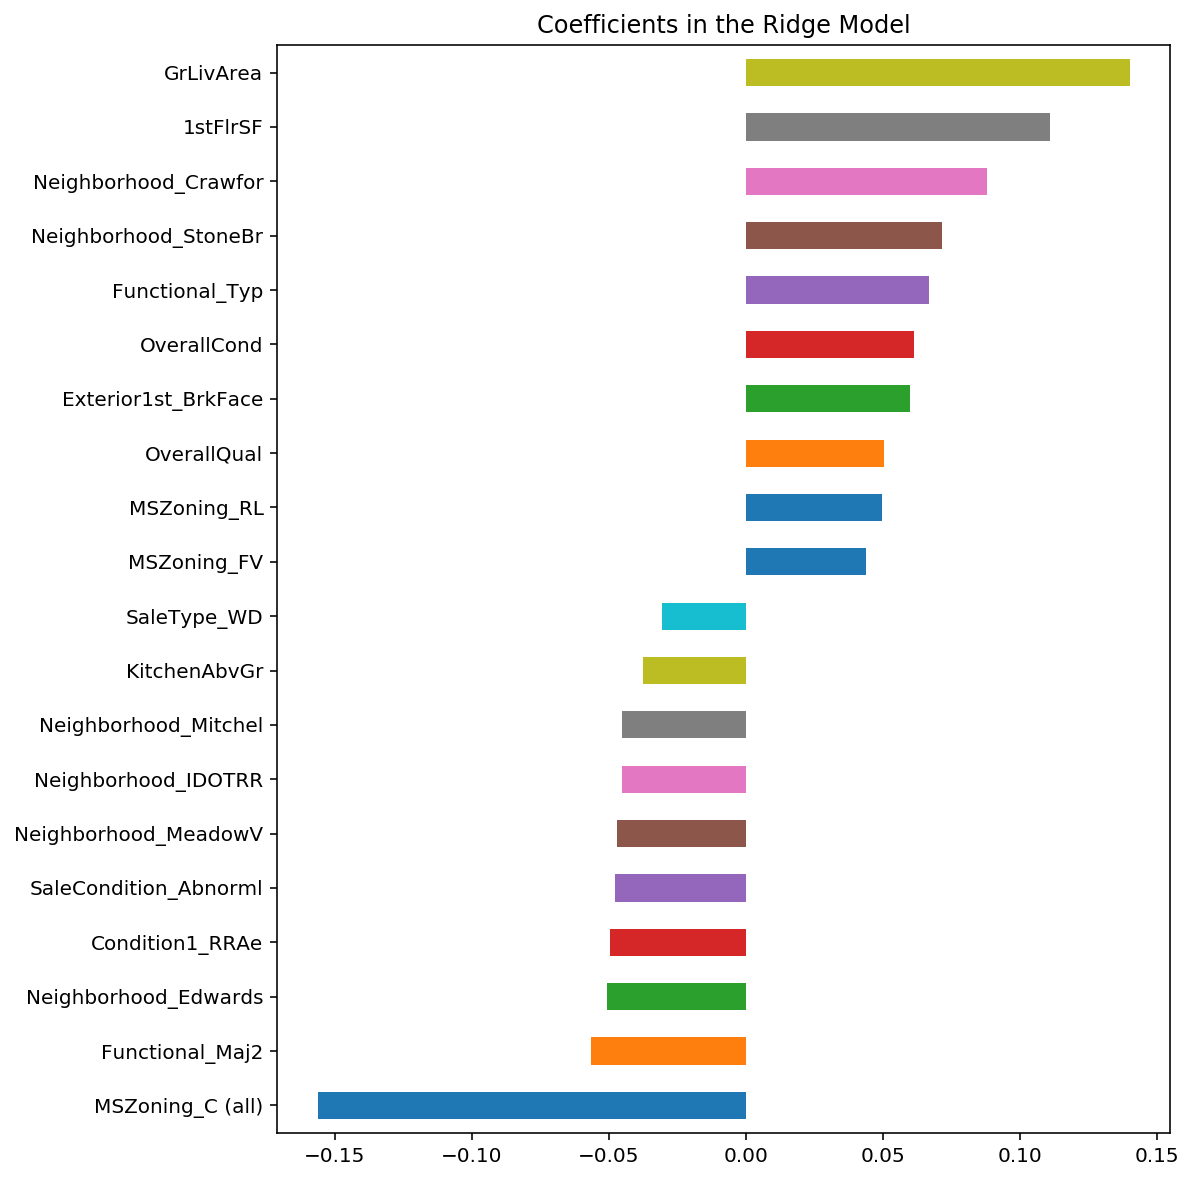

In [27]:
coef = pd.Series(model_ridge.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

### Lasso regression

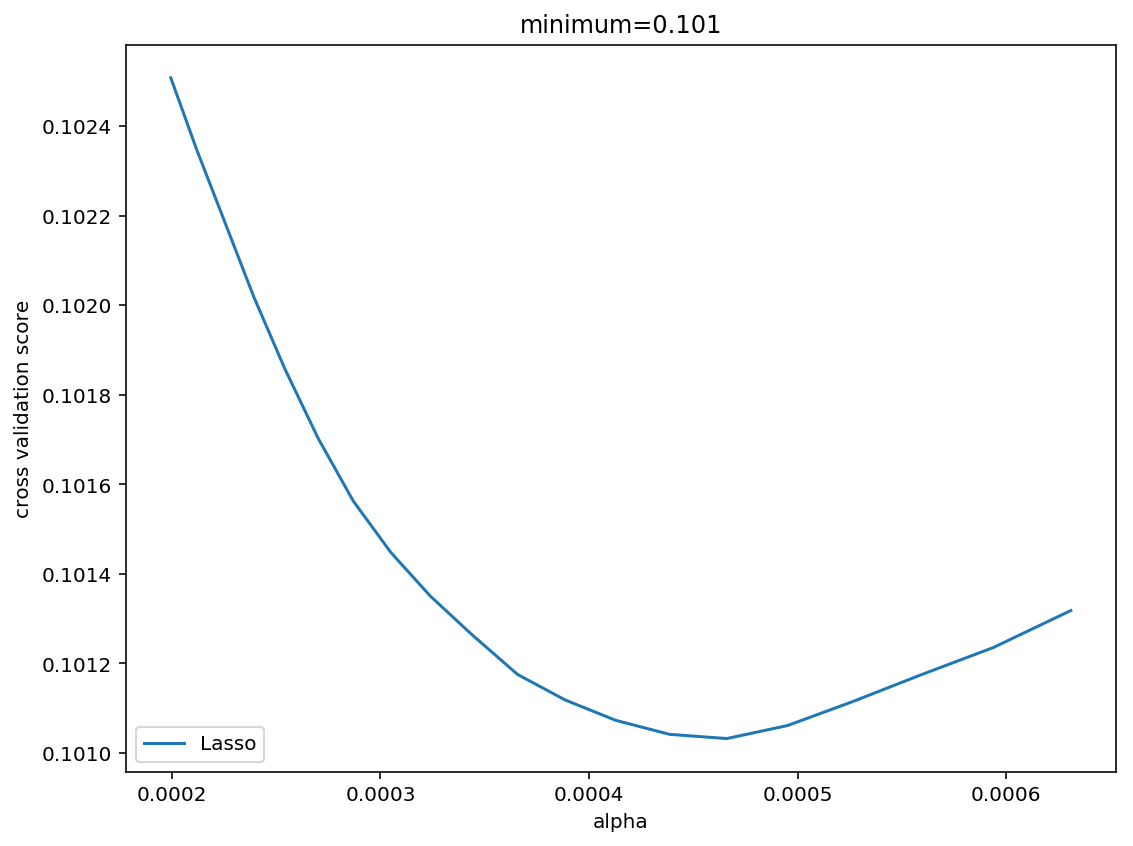

In [28]:
#Plotting cross-validation error for a range learning rates (alpha)
alphas = np.logspace(-3.7, -3.2, 20)

cv_lasso = [rmse_cv(make_pipeline(RobustScaler(),Lasso(alpha = alpha))).mean() 
            for alpha in alphas]

plt.figure(figsize=(8,6)) 
plt.plot(alphas, cv_lasso, label=Lasso.__name__)
plt.title('minimum=%1.3f' %min(cv_lasso))
plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [29]:
#setting the learning rate (alpha) equal to the optimum values (0.00045)
model_lasso = Lasso(alpha =0.00045, random_state=1)

### XGboost

In [32]:
my_pipeline = Pipeline([('RB', RobustScaler()), ('xgbrg', XGBRegressor())])

In [33]:
#Using GridSearchCV to tune hyperparameters
param_grid = {
    'xgbrg__max_depth': [2,3],
    'xgbrg__colsample_bytree': [0.2],
    'xgbrg__n_estimators': [2000],
    'xgbrg__learning_rate': [0.1, 0.05,]
}
searchCV = GridSearchCV(my_pipeline, cv=5, param_grid=param_grid)

In [34]:
searchCV.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('RB', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('xgbrg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, ma... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbrg__max_depth': [2, 3], 'xgbrg__colsample_bytree': [0.2], 'xgbrg__n_estimators': [2000], 'xgbrg__learning_rate': [0.1, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
#Identifying best hyperparameters
searchCV.best_params_ 

{'xgbrg__colsample_bytree': 0.2,
 'xgbrg__learning_rate': 0.05,
 'xgbrg__max_depth': 3,
 'xgbrg__n_estimators': 2000}

In [36]:
dtrain = xgb.DMatrix(X, label = y)
dtest = xgb.DMatrix(testing_features)

params = {  'colsample_bytree': 0.2,'eta':0.05, 'eval_metric': 'rmse',  'max_depth':3,'n_estimators': 2000}
model_xgb = xgb.cv(params, dtrain,  num_boost_round=2000, nfold=5, early_stopping_rounds=100)

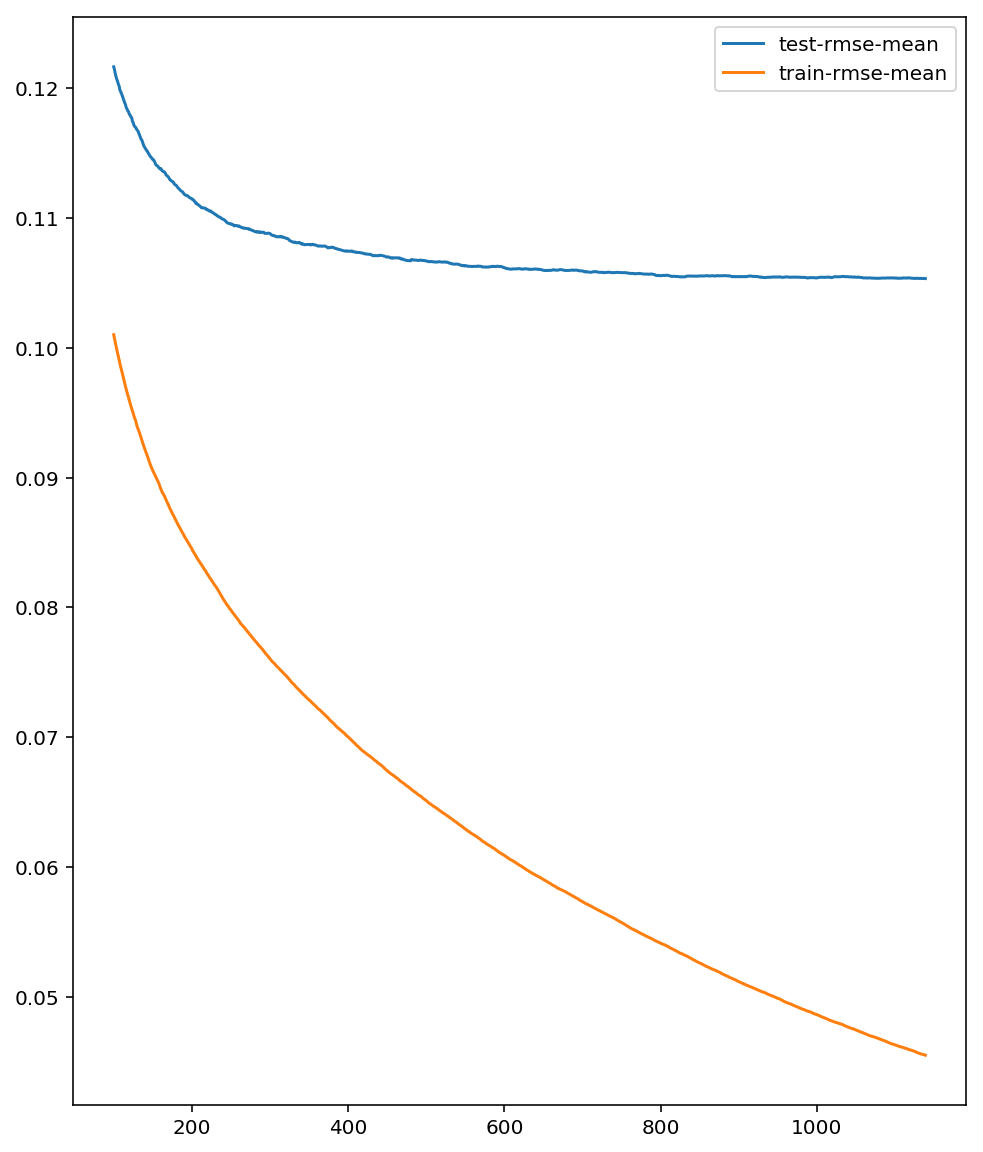

In [37]:
#Plotting learning curves for Xgboost model
model_xgb.loc[100:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [38]:
#Assigning ompitimized hyperparameters
model_xgb=XGBRegressor(max_depth=3, learning_rate=0.05,
                       n_estimators=2000, verbosity=1)

### Kernel Ridge Regression

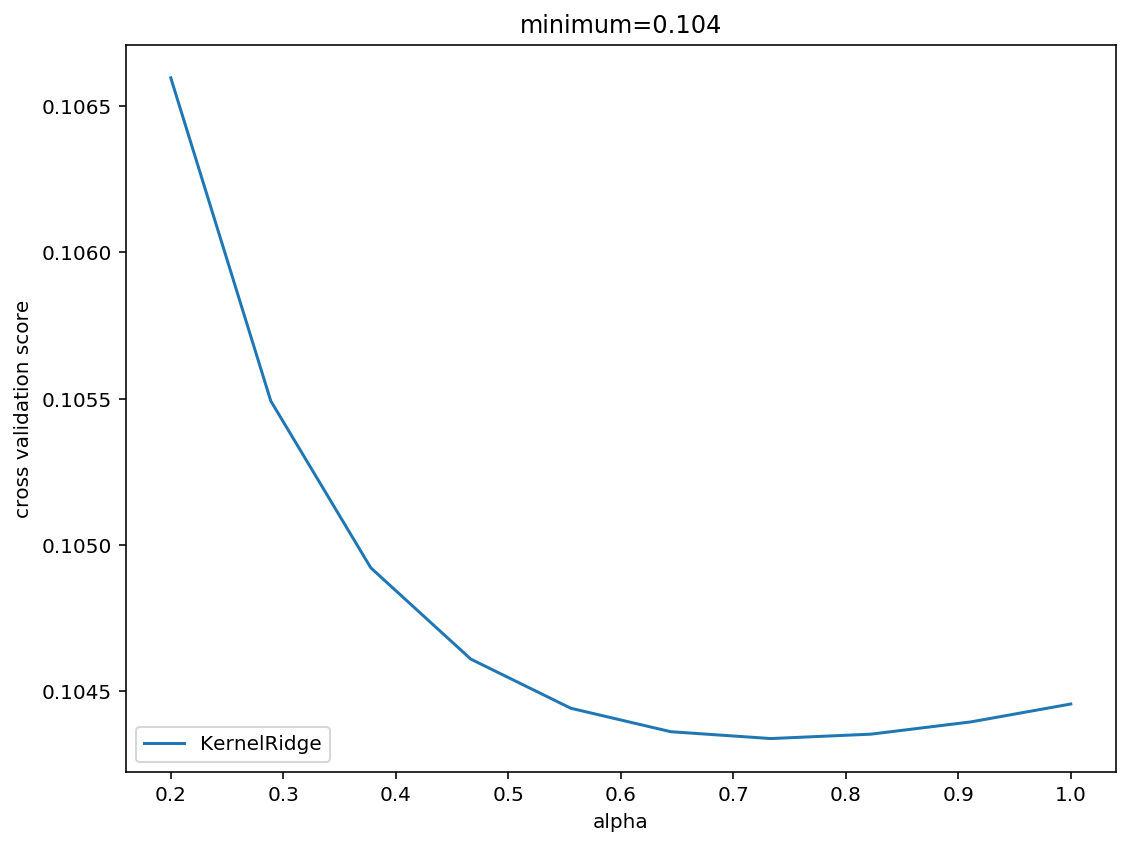

In [39]:
#Using variable "Varis" we scan over various hyperparameters to find optimom values
varis = np.linspace(.2, 1, 10)

cv_KRR = [rmse_cv(make_pipeline(RobustScaler(),
                                
                                KernelRidge(alpha=var,
                                kernel='polynomial',
                                gamma=None, degree=2, coef0=7))).mean()          
                                              for var in varis]

plt.figure(figsize=(8,6)) 
plt.plot(varis, cv_KRR, label=KernelRidge.__name__)
plt.title('minimum=%1.3f' %min(cv_KRR))
plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [40]:
model_KRR=KernelRidge(alpha=0.7,  kernel='polynomial', gamma=None, degree=2, coef0=7)

### Elastic Net Regression

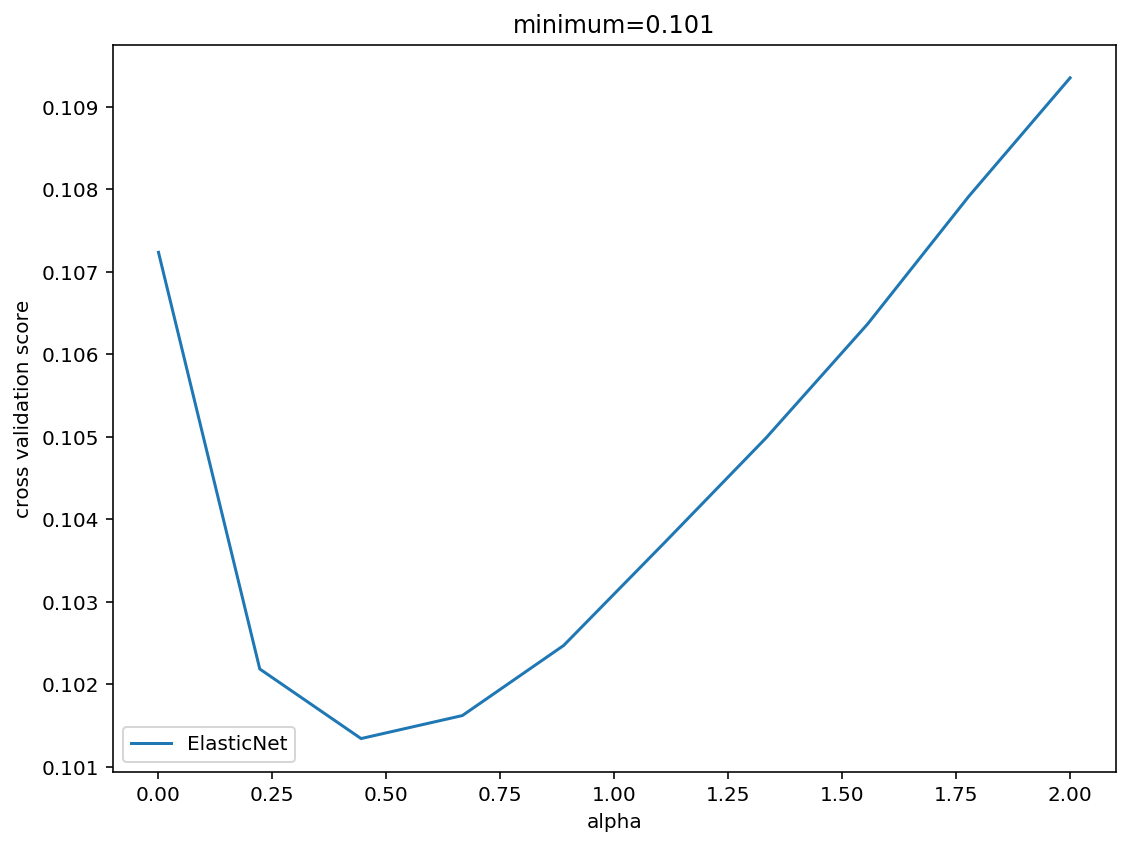

In [41]:
#Using variable "Varis" we scan over various hyperparameters to find optimom values
varis = np.linspace(0,2, 10)

cv_ElasticNet = [rmse_cv(make_pipeline(RobustScaler(),                                
                                ElasticNet(alpha=0.001, l1_ratio=var))).mean()          
                                              for var in varis]

plt.figure(figsize=(8,6)) 
plt.plot(varis, cv_ElasticNet, label=ElasticNet.__name__)
plt.title('minimum=%1.3f' %min(cv_ElasticNet))
plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()


In [42]:
model_Elastic=ElasticNet(alpha=0.001, l1_ratio=0.5)

# 4-Creating an ensemble by stacking various models 

In [61]:
#setup models in pipelines with RobustScaler 
ridge =make_pipeline(RobustScaler(),model_ridge)

lasso =make_pipeline(RobustScaler(), model_lasso)

xgboost =make_pipeline(RobustScaler(), model_xgb)

KRR =make_pipeline(RobustScaler(), model_KRR)

Elastic =make_pipeline(RobustScaler(), model_Elastic)


#Stacking various models and using Lasso regression as meta model
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, KRR, Elastic,xgboost), 
                               meta_regressor=Lasso(),
                               use_features_in_secondary=True)

#preparing dataframes
stackX = np.array(X)
stacky = np.array(y)

In [59]:
#Running Gridsearch to optimize hyperparameter for the meta model

grid = GridSearchCV(
    estimator=stack_gen, 
    param_grid={
        
        'meta_regressor__alpha': [0.0001,0.0005]
    }, 
    cv=5,
    refit=True
)



In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, KRR, Elastic,xgboost), 
                               meta_regressor=Lasso(alpha=0.0005),
                               use_features_in_secondary=True)

In [60]:
grid_fit=grid.fit(stackX, stacky)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.934889 using {'meta_regressor__alpha': 0.0005}


In [62]:
#Printing cross-validation score for various models including stacked ensembled model

print("cross validated scores")

for model, label in zip([ridge, lasso,KRR, Elastic,xgboost, stack_gen],
                     ['RidgeCV', 'LassoCV','KRRCV','ElasticCV','XGBoostCV', 'StackingCVRegressor']):
    
    SG_scores = cross_val_score(model, stackX, stacky, cv=5,
                               scoring='neg_mean_squared_error')
    print("RMSE", np.sqrt(-SG_scores.mean()), "SD", label)

cross validated scores
RMSE 0.10425373460322307 SD RidgeCV
RMSE 0.10117970572176395 SD LassoCV
RMSE 0.10447076490887214 SD KRRCV
RMSE 0.1014895130957834 SD ElasticCV
RMSE 0.11032227752440323 SD XGBoostCV
RMSE 0.10086403578663151 SD StackingCVRegressor


# 5-Making prediction on the test data

In [63]:
test=testing_features

In [64]:
stack_gen_fit =  stack_gen.fit(stackX,stacky) 

In [65]:
train_preds = stack_gen_fit.predict(X) 

In [66]:
print(rmsle(y, train_preds))

0.0776373458714321


In [67]:
stack_gen_preds = stack_gen_fit.predict(testing_features) 


In [75]:
ridge_fit=ridge.fit(X,y)
lasso_fit=lasso.fit(X,y)
xgboost_fit=xgboost.fit(X,y)
KRR_fit=KRR.fit(X,y)
Elastic_fit=Elastic.fit(X,y)


In [76]:
ridge_pred=ridge_fit.predict(testing_features)
lasso_pred=lasso_fit.predict(testing_features)
xgboost_pred=xgboost_fit.predict(testing_features)
KRR_pred=KRR_fit.predict(testing_features)
Elastic_pred=Elastic_fit.predict(testing_features)

In [78]:
preds = stack_gen_preds

In [79]:
submission = pd.read_csv("sample_submission.csv")

In [80]:
submission.iloc[:,1] = np.expm1(preds)

In [81]:
submission.to_csv("Stacked_submission.csv", index=False)